# Facial Recogntion System with Face Liveness Detection

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show/Hide Code"></form>''')

## Introduction

__Facial Recognition__ is one of the popular ways for identity verification in current time which has been used in many different industry.  
__Liveness Detection__ is very important when it comes to face recognition. A vanilla face recognition can be easily spoofed by a print image or a recorded video. So in order to make facial recognition system safe from such attacks, it has to be designed such a way that it could tell the difference between a Live Video or if it is being spoofed, that's where Liveness Detection plays a very important role.  
  
Liveness Detection can be approached in two ways:  

1. __Passive way__: User will be told to do some gestures like tilting head, blinking, etc. This is somewhat easier to implement but it's troublesome for user to do these gestures and that's the reason business doesn't prefer this approach.
2. __Active way__: User isn't told to do any kind of gesture and just on the basis of regular video the algorithm should be able to tell that whether it is a live video or if it is being spoofed. This is more convenient for end user but at the same time it is more difficult to implement and will require more data.

If __Liveness Detection__ part says that it is a live video, then only Facial recognition code will be invoked through the API since there is no point of doing facial recognition when it is being spoofed with print image or recorded video.  
If liveness detection part says that it is being spoofed, then customer will be generated a warning on the screen.

![title](images/Liveness-Detection.jpg)

## Objective

In [2]:
# from IPython.display import display
# from IPython.display import HTML
# import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# # This line will hide code by default when the notebook is exported as HTML
# di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# # This line will add a button to toggle visibility of code blocks, for use with the HTML export version
# di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

To develop a __Facial Recogntion system__ with inherent capability of __Face Liveness Detection system (Active way)__.

## System Pipeline

1. __Photo Collection__: Few photos of all the people, whose face need to be recognized, have to be put in the folder named __People__.
2. __Face Encoding__: For all these images face has been detected and then for these detected faces, Face encodings of all these people has been computed and saved as a dictioinary. For __Face Detection__, __Face Encoding__, and __Face Recognition__; _face_recognition_ API has been used which is built on _dlib's_ state-of-the-art face recognition based on Deep Learning.
3. __Liveness Detection Model Training__: Once we have the face encodings of all the people and we have trained a deep learning model for face liveness detection based on __3DCNN__.
4. __Video Capture__: Now webcam is turned on for video capturing.
5. __Liveness Prediction__: These captured video frames are sent to face liveness detection model for prediction.
6. __Facial Recongtion__: If liveness detection predicts, with more than a certain probability, that it is a live video then it is sent to _face_recogntion_ API for facial recognition.
7. __Warning__: If Liveness Detection says that it is being spoofed then a _Warning_ is generated on the screen to the end user.


![title](images/Flowchart_1.jpeg)

## Result Demo

In [26]:
# %%HTML
# <div align="middle">
# <video width="80%" controls>
#       <source src="images/VID-20180616-WA0032.mp4" type="video/mp4">
# </video></div>


## Implementation

### Dataset

__ROSE-Youtu Face Liveness Detection Dataset__ has been used for training the Liveness detection model.   
Few details regarding this dataset are as follows:  
1. This dataset contains around 3500 videos from 20 subjects. 
2. For each subject, there are 150-200 video clips with an average duration of around 10 seconds. 
3. Five mobile phones were used to collect the database. 
4. All face videos are captured by a front-facing camera. 
5. The standoff distance between the face and camera is about 30-50 cm.
6. Three spoofing attack types including printed paper attack, video replay attack, and masking attack are considered. Masking attack is of three types: __Full mask, Cropped mask__, and __Upper mask__.
7. Moreover, the face videos are captured with different backgrounds which guarantee the face videos are coupled with different illumination conditions.

More details regarding the dataset can be found out here http://rose1.ntu.edu.sg/Datasets/faceLivenessDetection.asp.


![title](images/ImageGrid_1.png)

In [5]:
import os
from os.path import isfile, join
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import cv2, glob
import keras
from keras.models import model_from_json
from keras.models import Sequential, Model
import keras.backend as K
from keras.layers import Conv3D, MaxPooling3D, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.preprocessing import image
from keras import Input, layers
from keras import optimizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, Callback, EarlyStopping
from keras.utils import to_categorical

import face_recognition

Using TensorFlow backend.


### Data Analysis

In [6]:
base_dir= '/Users/m0a04ut/MyData/Studz/Fast/'
original_model_filename= base_dir+"LivenessDetectionCodes/LivenessDetectionRunning/model/model.h5"
finetuned_model_filename= base_dir+"LivenessDetectionCodes/LivenessDetectionRunning/model/finetuned_model.h5"
init_lr= 0.001
n_frames_liveness= 24
batch_sz= 128
n_class= 2
num_vids_per_batch = 5
n_epochs= 10
do_finetune = False #set True if you want to finetune the model
font = cv2.FONT_HERSHEY_DUPLEX

In [7]:
onlyfolders = [f for f in os.listdir(base_dir+'LivenessDetectionDataset/NTU_ROSE_Dataset/') if not isfile(join(base_dir, f))]
all_videos= []
for folder in onlyfolders:
    files= os.listdir(base_dir+'LivenessDetectionDataset/NTU_ROSE_Dataset/'+folder)
    all_videos.extend(files)
print("Total number of video files are: ", len(all_videos))

Total number of video files are:  3497


In [8]:
tag_1= [x.split('_')[0] for x in all_videos]
tag_1= [x[0] for x in tag_1]
tag_1= pd.DataFrame(tag_1, columns= ['tag'])
tag_1[tag_1['tag']=='M']= 'Mask'
tag_1[tag_1['tag']=='G']= 'Genuine'
tag_1[tag_1['tag']=='V']= 'Recorded video'
tag_1[tag_1['tag']=='P']= 'Print'
tag_1.loc[tag_1['tag'].isin(['Mask', 'Recorded video', 'Print']), 'tag_Attack_Genuine']= 'Attack'
tag_1.loc[tag_1['tag']=='Genuine', 'tag_Attack_Genuine']= 'Genuine'
print(tag_1['tag'].value_counts(), tag_1['tag_Attack_Genuine'].value_counts())

Mask              999
Genuine           897
Recorded video    801
Print             800
Name: tag, dtype: int64 Attack     2600
Genuine     897
Name: tag_Attack_Genuine, dtype: int64


Text(0.5, 1.0, 'Count of Genuine and combnined attacks video files')

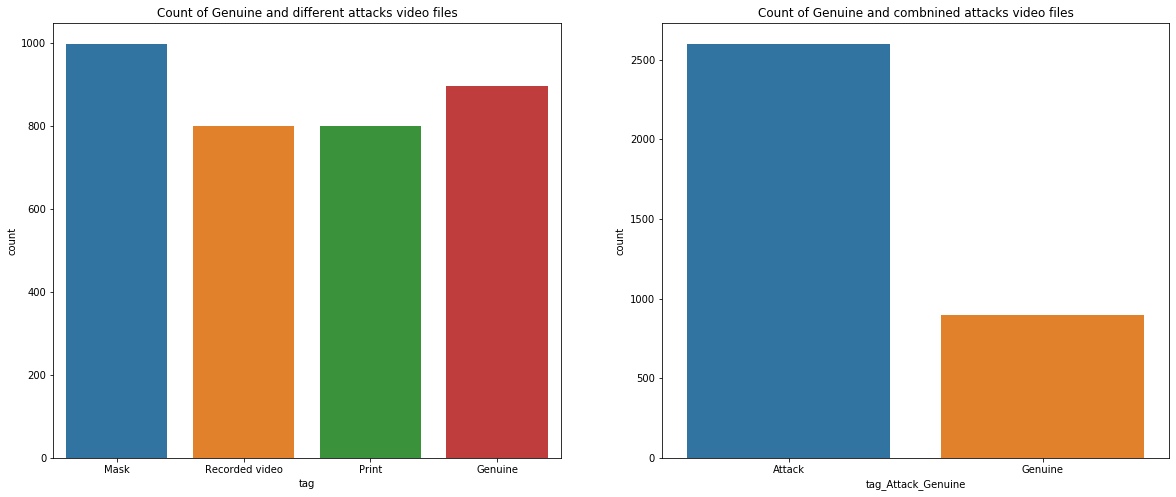

In [9]:
f, axes = plt.subplots(1, 2, figsize=(20,8))
sns.countplot(x="tag", data=tag_1, ax= axes[0])
sns.countplot(x="tag_Attack_Genuine", data=tag_1, ax= axes[1])
axes[0].set_title('Count of Genuine and different attacks video files')
axes[1].set_title('Count of Genuine and combnined attacks video files')

### Traning and validation data preparation


1. Data from 2 subjects has been used for validation and remaining 18 is being used for training.
2. 24 frames are being processed at once and being passed to 3DCNN.
3. All the frames are being resized to 100\*100 before being passed to CNN.

In [10]:
def read_files(folders):
    all_files, all_labels= [], []

    for folder in folders:
        files= os.listdir(base_dir+'LivenessDetectionDataset/NTU_ROSE_Dataset/'+folder)
        for file in files:
            all_files.append(base_dir+'LivenessDetectionDataset/NTU_ROSE_Dataset/'+folder + "/"+ file)
            tag= file.split('_')[0]
            if(tag=='G'):
                all_labels.append([1,0])
            else:
                all_labels.append([0,1])
    return (all_files, all_labels)

In [11]:
val_folders= random.sample(onlyfolders, 2)
train_folders= [folder for folder in onlyfolders if folder not in val_folders]
train_input_files, train_file_labels = read_files(train_folders)
val_input_files, val_file_labels = read_files(val_folders)

In [12]:
#following lines output number of frames in a video file
# cap = cv2.VideoCapture(base_dir+'LivenessDetectionDataset/NTU_ROSE_Dataset/'+"20"+"/Mc_T_HW_g_E_20_65.mp4")
# length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# print( length )

### Distribution after training and validation split

In [13]:
val_input_files, val_file_labels= np.array(val_input_files), np.array(val_file_labels)
train_input_files, train_file_labels= np.array(train_input_files), np.array(train_file_labels)
train_file_labels_unique= np.unique(train_file_labels, axis=0, return_counts= True)
val_file_labels_unique= np.unique(val_file_labels, axis=0, return_counts= True)
train_file_labels_unique_df= pd.DataFrame(train_file_labels_unique[0], columns=['0','1'])
val_file_labels_unique_df= pd.DataFrame(val_file_labels_unique[0], columns=['0','1'])
train_file_labels_unique_df['Count']= train_file_labels_unique[1]
val_file_labels_unique_df['Count']= val_file_labels_unique[1]
train_file_labels_unique_df.loc[train_file_labels_unique_df['0']==0, 'type']= 'Attack'
train_file_labels_unique_df.loc[train_file_labels_unique_df['0']==1, 'type']= 'Genuine'
val_file_labels_unique_df.loc[val_file_labels_unique_df['0']==0, 'type']= 'Attack'
val_file_labels_unique_df.loc[val_file_labels_unique_df['0']==1, 'type']= 'Genuine'
train_file_labels_unique_df= train_file_labels_unique_df[['Count', 'type']]
val_file_labels_unique_df= val_file_labels_unique_df[['Count', 'type']]
train_val_cnt= pd.DataFrame(columns=['train_val', 'Count'])
train_val_cnt['Count']= [train_input_files.shape[0], val_input_files.shape[0]]
train_val_cnt['train_val']= ['train', 'val']

Text(0.5, 1.0, 'number of Genuine and attacks samples in validation')

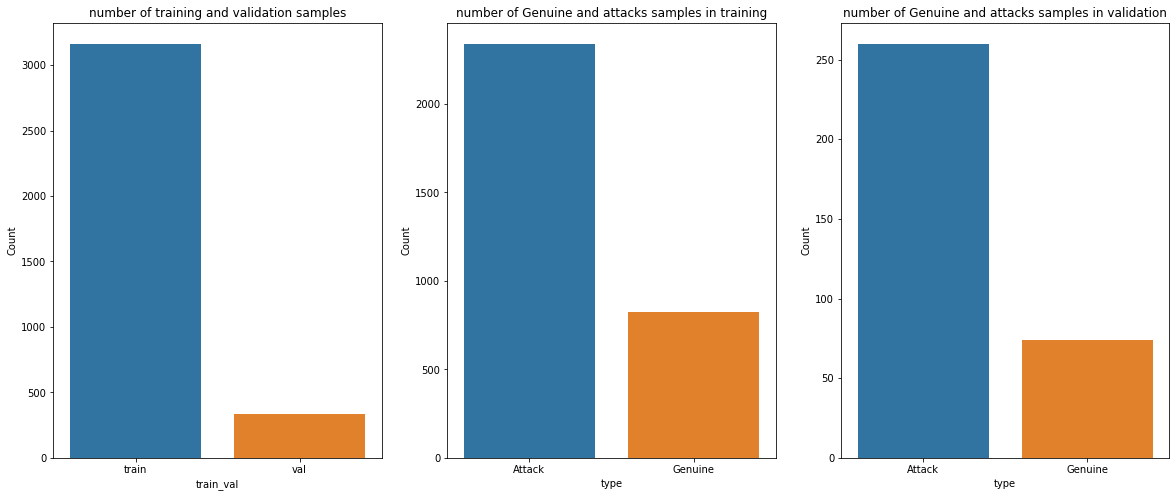

In [14]:
f, axes = plt.subplots(1, 3, figsize=(20,8))
sns.barplot(x="train_val", y= "Count", data=train_val_cnt, ax= axes[0])
sns.barplot(x="type", y= "Count", data=train_file_labels_unique_df, ax= axes[1])
sns.barplot(x="type", y= "Count", data=val_file_labels_unique_df, ax= axes[2])
axes[0].set_title('number of training and validation samples')
axes[1].set_title('number of Genuine and attacks samples in training')
axes[2].set_title('number of Genuine and attacks samples in validation')

In [15]:
def data_generator(files, num_vids_per_batch, n_frames_liveness):
    X, Y= [], []
    n= 0
    while True:
        for file in files:
            print(file)
            vidcap = cv2.VideoCapture(file)
            ret= 1
            count= 0 # this tracks the number of frames in a data point
            frames= []
            n+=1 # this tracks number of videos in current batch
            while ret:
                ret,frame = vidcap.read()
                if(not ret): break
                frame = cv2.resize(frame, (100,100))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frames.append(frame)
                count += 1
                if(count==n_frames_liveness):
                    X.append(frames)
                    frames= []
                    count= 0
                    tag= file.split('_')[0]
                    if(tag=='G'):
                        Y.append([1,0])
                    else:
                        Y.append([0,1])
            if (n==num_vids_per_batch):
                X, Y= np.array(X), np.array(Y)
                X= X.reshape(X.shape[0], n_frames_liveness, 100, 100, 1)
                yield [X, Y]
                n= 0 
                X, Y = [], []                                    

In [16]:
# ###### run this for testing the data_generator function ############
# for aa in data_generator(train_input_files[:7], 3, 24):
#     print(aa[0].shape, aa[1].shape,  np.max(aa[0]), np.max(aa[1]), np.min(aa[0]), np.min(aa[1]))
    
    

In [17]:
# def read_frames(folders):
#     inp_frames= []
#     labels= []
#     for folder in folders:
#         files= os.listdir(base+'LivenessDetectionDataset/NTU_ROSE_Dataset/'+folder)
#         for file in files:
#             vidcap = cv2.VideoCapture(base+'LivenessDetectionDataset/NTU_ROSE_Dataset/'+folder+'/'+file)
#             ret= 1
#             count= 0
#             frames= []
#             while ret:
#                 ret,frame = vidcap.read()
#                 if(not ret): break
#                 frame = cv2.resize(frame, (100,100))
#                 frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#                 frames.append(frame)
#                 count += 1
#                 if(count==24):
#                     inp_frames.append(frames)
#                     frames= []
#                     count= 0
#                     tag= file.split('_')[0]
#                     if(tag=='G'):
#                         labels.append([1,0])
#                     else:
#                         labels.append([0,1])
#     return inp_frames, labels

                                    

In [18]:
# val_input_frames, val_labels = read_frames(val_folders)
# train_input_frames, train_labels = read_frames(train_folders)


In [19]:
# np.save(base+'LivenessDetectionCodes/LivenessDetectionRunning/TrainTestData/val_input_frames.npy', val_input_frames)
# np.save(base+'LivenessDetectionCodes/LivenessDetectionRunning/TrainTestData/val_labels.npy', val_labels)
# np.save(base+'LivenessDetectionCodes/LivenessDetectionRunning/TrainTestData/train_input_frames.npy', train_input_frames)
# np.save(base+'LivenessDetectionCodes/LivenessDetectionRunning/TrainTestData/train_labels.npy', train_labels)

In [20]:
# val_input_frames= np.load(base+'LivenessDetectionCodes/LivenessDetectionRunning/TrainTestData/val_input_frames.npy') 
# val_labels= np.load(base+'LivenessDetectionCodes/LivenessDetectionRunning/TrainTestData/val_labels.npy')
# train_input_frames= np.load(base+'LivenessDetectionCodes/LivenessDetectionRunning/TrainTestData/train_input_frames.npy')
# train_labels= np.load(base+'LivenessDetectionCodes/LivenessDetectionRunning/TrainTestData/train_labels.npy')

In [21]:
# val_input_frames, val_labels= np.array(val_input_frames), np.array(val_labels)
# train_input_frames, train_labels= np.array(train_input_frames), np.array(train_labels)
# train_labels_unique= np.unique(train_labels, axis=0, return_counts= True)
# val_labels_unique= np.unique(val_labels, axis=0, return_counts= True)
# train_labels_unique_df= pd.DataFrame(train_labels_unique[0], columns=['0','1'])
# val_labels_unique_df= pd.DataFrame(val_labels_unique[0], columns=['0','1'])
# train_labels_unique_df['Count']= train_labels_unique[1]
# val_labels_unique_df['Count']= val_labels_unique[1]
# train_labels_unique_df.loc[train_labels_unique_df['0']==0, 'type']= 'Attack'
# train_labels_unique_df.loc[train_labels_unique_df['0']==1, 'type']= 'Genuine'
# val_labels_unique_df.loc[val_labels_unique_df['0']==0, 'type']= 'Attack'
# val_labels_unique_df.loc[val_labels_unique_df['0']==1, 'type']= 'Genuine'
# train_labels_unique_df= train_labels_unique_df[['Count', 'type']]
# val_labels_unique_df= val_labels_unique_df[['Count', 'type']]
# train_val_cnt= pd.DataFrame(columns=['train_val', 'Count'])
# train_val_cnt['Count']= [train_input_frames.shape[0], val_input_frames.shape[0]]
# train_val_cnt['train_val']= ['train', 'val']
# #resshape train and val input such that it has one channel for CNN input
# val_input_frames= val_input_frames.reshape(val_input_frames.shape[0],n_frames_liveness,100,100,1) 
# train_input_frames= train_input_frames.reshape(train_input_frames.shape[0],n_frames_liveness,100,100,1)

### Model Training/Finetuning

In [22]:
def create_liveness_model(n_frames_liveness):

    model = Sequential()
    model.add(Conv3D(32, kernel_size=(3, 3, 3),
                    activation='relu',
                    input_shape=(n_frames_liveness,100,100,1))) #this need to be changed to 24
    model.add(Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_class, activation='softmax'))
    optimizer = Adam(lr=init_lr, decay=init_lr / n_epochs)
#   model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics= ["accuracy", custom_metric])
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics = ["acc"]) #for multilabel classification loss is always binary_crossentropy. this should not change.
    return model


In [ ]:
# this callback function is used to plot the training/val accuracy and losses while training
class TrainingPlot(Callback):

    def __init__(self, filename= None):
        self.filename = filename

    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):

        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))

        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(1, len(self.losses)+1)

            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")

            # Plot train loss, train acc, val loss and val acc against epochs passed
            fig = plt.figure(figsize= (25,12))
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch+1))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()
            # Make sure there exists a folder called output in the current directory
            # or replace 'output' with whatever direcory you want to put in the plots
        if (filename != None and epoch == (N_EPOCHS -1)):
            fig.savefig(self.filename)
            plt.close()

In [64]:
class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range to start the training with for your model + dataset. This optimal learning rate will
    be used as max_lr in SGDRScheduler or initial learning rate in general.
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)
        self.history.setdefault('val_acc', []).append(logs.get("val_acc"))
        self.history.setdefault('val_loss', []).append(logs.get("val_loss"))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate (log scale)')
        plt.title("ITERATION VS LEARNING RATE")
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate (log scale)')
        plt.ylabel('Loss')
        plt.title("LEARNING RATE VS LOSS")
        plt.show()

In [65]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length
        self.trn_iterations = 0

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.trn_iterations += 1
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        self.history.setdefault('val_acc', []).append(logs.get("val_acc"))
        self.history.setdefault('val_loss', []).append(logs.get("val_loss"))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        
        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)


In [71]:
def do_finetune_model(model, finetuned_model_filename):
    start= time()
    train_steps = np.ceil(len(train_input_files)/num_vids_per_batch)
    val_steps = np.ceil(len(val_input_files)/num_vids_per_batch)
    
    #create all the callbacks
    checkpoint = ModelCheckpoint(finetuned_model_filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    reduce_on_plateau = ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.2, patience=2, verbose=1)
    earlystop = EarlyStopping(monitor= 'val_loss', min_delta=0.5, patience=1, verbose=0, mode='max')
    lr_finder = LRFinder(min_lr=1e-5, max_lr=1e-2, steps_per_epoch=train_steps, epochs= N_EPOCHS)
    schedule = SGDRScheduler(min_lr=5e-5, max_lr=1e-2, steps_per_epoch=train_steps, lr_decay=0.8, cycle_length=1,mult_factor=2)
    plot_losses = TrainingPlot()
    callbacks_list = [checkpoint, schedule, plot_losses]
    
    train_generator= data_generator(train_input_files, num_vids_per_batch, n_frames_liveness)
    val_generator= data_generator(val_input_files, num_vids_per_batch, n_frames_liveness)
    
    history= model.fit_generator(train_generator, validation_data= val_generator, epochs= n_epochs, steps_per_epoch=train_steps, 
                             validation_steps= val_steps, callbacks=callbacks_list, verbose=1)
                            # use_multiprocessing=True, workers=4)
        
    print("TIME TAKEN IN SECONDS: ", time()-start)
    return model

In [80]:
def get_model(do_finetune= False):
    
    model = create_liveness_model(n_frames_liveness)
    # load weights into new model
    model.load_weights(original_model_filename)
    print("Loaded model from disk")
    
    if (do_finetune == True):
        return  do_finetune_model(model, finetuned_model_filename)
    else:
        return model

In [89]:
def get_users():
    known_names=[]
    known_encods=[]

    for i in glob.glob(base_dir+"LivenessDetectionCodes/LivenessDetectionRunning/people/*.jpg"):
        img = face_recognition.load_image_file(i)
        encoding = face_recognition.face_encodings(img)[0]
        known_encods.append(encoding)
        known_names.append(i[7:-4])

    return known_names, known_encods

In [3]:
def main_function():
    model = get_model(n_frames_liveness)
    known_names, known_encods = get_users()
    video_capture = cv2.VideoCapture(0)
    video_capture.set(3, 640)
    video_capture.set(4, 480)

    # Initialize some variables
    face_locations = []
    face_encodings = []
    face_names = []
    process_this_frame = True
    input_vid = []

    while True:
        # Grab a single frame of video
        if len(input_vid) < n_frames_liveness: #here 24 is the number of frames which need to be passed to the liveness model as one test input datapoint. We can reduce this 24 to make the model more responsive/fast.

            ret, frame = video_capture.read()

            liveimg = cv2.resize(frame, (100,100))
            liveimg = cv2.cvtColor(liveimg, cv2.COLOR_BGR2GRAY)
            input_vid.append(liveimg)
        else:
            ret, frame = video_capture.read()

            liveimg = cv2.resize(frame, (100,100))
            liveimg = cv2.cvtColor(liveimg, cv2.COLOR_BGR2GRAY)
            input_vid.append(liveimg)
            inp = np.array([input_vid[-n_frames_liveness:]])
            inp = inp/255
            inp = inp.reshape(1,n_frames_liveness,100,100,1)
            pred = model.predict(inp)
            input_vid = input_vid[-25:]  #this 25 can also be changed to (n_frames_liveness-1)

            if pred[0][0]> prob_liveness:

                # Resize frame of video to 1/4 size for faster face recognition processing
                small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)

                # Only process every other frame of video to save time
                if process_this_frame:
                    # Find all the faces and face encodings in the current frame of video
                    face_locations = face_recognition.face_locations(small_frame)
                    face_encodings = face_recognition.face_encodings(small_frame, face_locations)
                    name = "Unknown"
                    face_names = []
                    for face_encoding in face_encodings:
                        for ii in range(len(known_encods)):
                            # See if the face is a match for the known face(s)
                            match = face_recognition.compare_faces([known_encods[ii]], face_encoding)

                            if match[0]:
                                name = known_names[ii]

                        face_names.append(name)

                process_this_frame = not process_this_frame

                unlock = False
                for n in face_names:

                    if n != 'Unknown':
                        unlock=True

                # Display the results
                for (top, right, bottom, left), name in zip(face_locations, face_names):
                    # Scale back up face locations since the frame we detected in was scaled to 1/4 size
                    top *= 4
                    right *= 4
                    bottom *= 4
                    left *= 4

                    # Draw a box around the face
                    cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

                    # Draw a label with a name below the face
                    cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)

                    cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)
                    if unlock:
                        cv2.putText(frame, 'UNLOCK', (frame.shape[1]//2, frame.shape[0]//2), font, 1.0, (255, 255, 255), 1)
                    else:
                        cv2.putText(frame, 'LOCKED!', (frame.shape[1]//2, frame.shape[0]//2), font, 1.0, (255, 255, 255), 1)
            else:
                cv2.putText(frame, 'WARNING!', (frame.shape[1]//2, frame.shape[0]//2), font, 1.0, (255, 255, 255), 1)
            # Display the liveness score in top left corner     
            cv2.putText(frame, "Prob of Liveness: "+ str(round(pred[0][0],5)), (20, 20), font, 1.0, (255, 255, 0), 1)
            # Display the resulting image
            cv2.imshow('Video', frame)

            # Hit 'q' on the keyboard to quit!
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break


In [4]:
main_function()
video_capture.release()
cv2.destroyAllWindows()

NameError: name 'get_model' is not defined